## Generating graph

In [ ]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

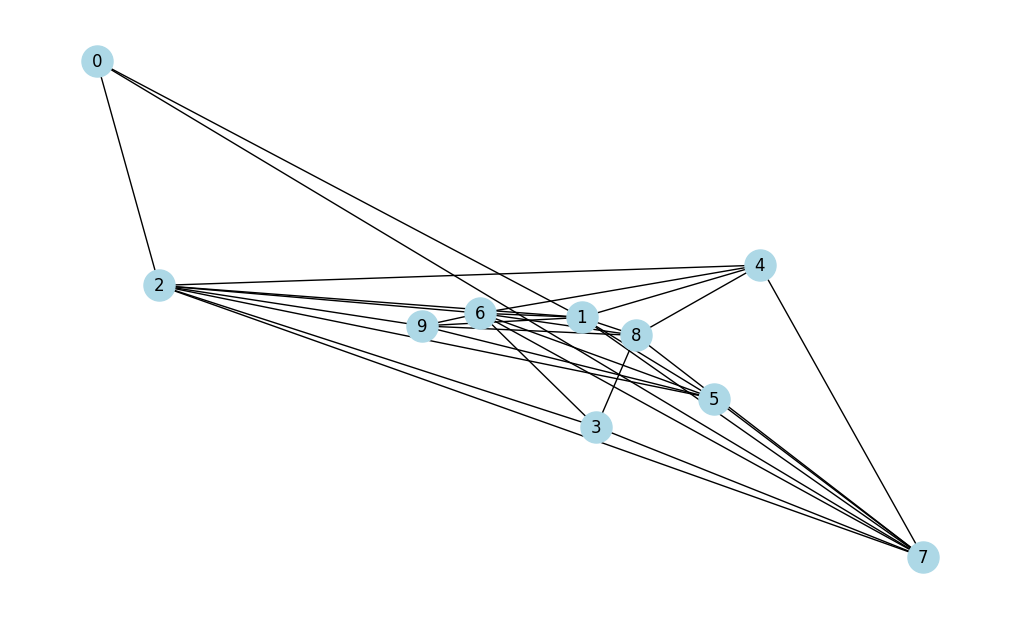

In [ ]:
G = gnp_random_connected_graph(10, 0.5, False, True)

# For Task 2

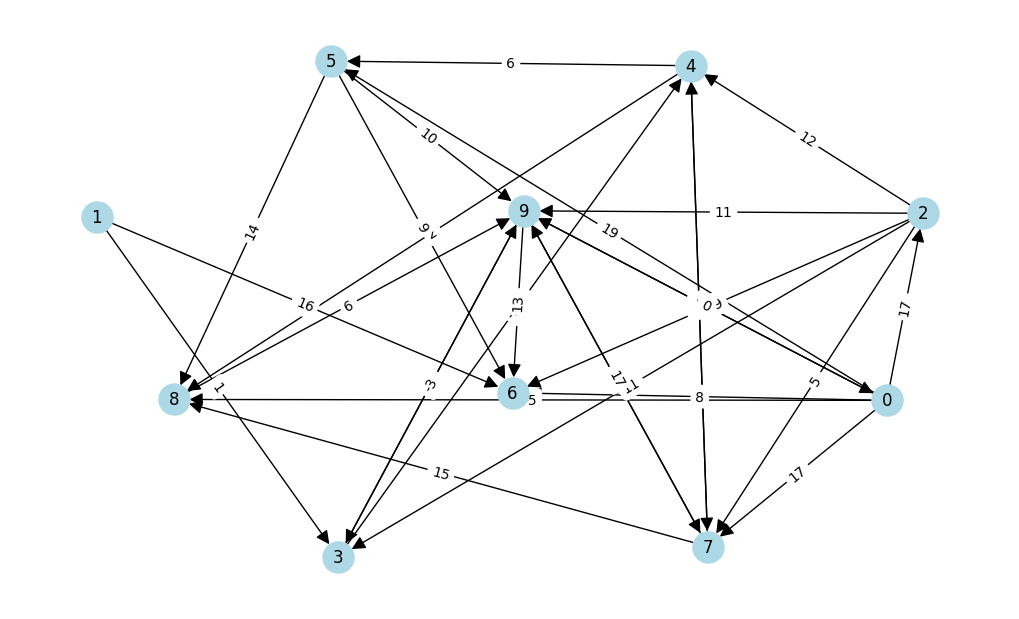

In [ ]:
G = gnp_random_connected_graph(10, 0.5, True, True)

## Bellman-Ford algorithm

In [ ]:
from networkx.algorithms import bellman_ford_predecessor_and_distance

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Negative cycle detected


## Floyd-Warshall algorithm

In [ ]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 2: 17, 5: 3, 6: 8, 7: 0, 8: -5, 9: -2, 1: inf, 3: -2, 4: -3}
Distances with 1 source: {1: 0, 3: -2, 6: 9, 0: 1, 2: 18, 4: -3, 5: 3, 7: 0, 8: -4, 9: -2}
Distances with 2 source: {2: 0, 7: 2, 3: 0, 4: -1, 6: 9, 9: 0, 0: 3, 1: inf, 5: 5, 8: -2}
Distances with 3 source: {3: -3, 4: -4, 9: -3, 0: 0, 1: inf, 2: 17, 5: 2, 6: 8, 7: -1, 8: -5}
Distances with 4 source: {4: -3, 5: 3, 7: 0, 8: -4, 0: 1, 1: inf, 2: 18, 3: -2, 6: 9, 9: -2}
Distances with 5 source: {5: 0, 8: 5, 6: 9, 9: 7, 0: 10, 1: inf, 2: 27, 3: 7, 4: 6, 7: 9}
Distances with 6 source: {6: 0, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 7: inf, 8: inf, 9: inf}
Distances with 7 source: {7: -3, 4: -6, 8: -7, 9: -5, 0: -2, 1: inf, 2: 15, 3: -5, 5: 0, 6: 6}
Distances with 8 source: {8: 0, 9: 3, 0: 6, 1: inf, 2: 23, 3: 3, 4: 2, 5: 8, 6: 14, 7: 5}
Distances with 9 source: {9: -6, 0: -3, 3: -6, 6: 5, 7: -4, 1: inf, 2: 14, 4: -7, 5: -1, 8: -8}


## Some useful explanations

### How to get list of edges for your algorithm

In [ ]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [ ]:
edges[:5]

[(0, 2), (0, 5), (0, 6), (0, 7), (0, 8)]

### To get edges with weights

In [ ]:
edges = list(G.edges(data=True))

In [ ]:
edges[:5]

[(0, 2, {'weight': 17}),
 (0, 5, {'weight': 19}),
 (0, 6, {'weight': 8}),
 (0, 7, {'weight': 17}),
 (0, 8, {'weight': -5})]

In [ ]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [ ]:
import time
from tqdm import tqdm

In [ ]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

  0%|          | 0/1000 [00:00<?, ?it/s]

0.00309446382522583